In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from scipy.stats import skew
from math import sqrt

warnings.filterwarnings('ignore')
%matplotlib inline

C:\Users\STEVEN\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
df = pd.read_csv(r'C:\Users\STEVEN\Documents\Thinkful\Files\Housing\Melbourne_housing_FULL.csv')

In [3]:
# lets take a look at the top of our data set to see if we have loaded everything in

print(df.head())

       Suburb             Address  Rooms Type      Price Method SellerG  \
0  Abbotsford       68 Studley St      2    h        NaN     SS  Jellis   
1  Abbotsford        85 Turner St      2    h  1480000.0      S  Biggin   
2  Abbotsford     25 Bloomburg St      2    h  1035000.0      S  Biggin   
3  Abbotsford  18/659 Victoria St      3    u        NaN     VB  Rounds   
4  Abbotsford        5 Charles St      3    h  1465000.0     SP  Biggin   

        Date  Distance  Postcode      ...       Bathroom  Car  Landsize  \
0  3/09/2016       2.5    3067.0      ...            1.0  1.0     126.0   
1  3/12/2016       2.5    3067.0      ...            1.0  1.0     202.0   
2  4/02/2016       2.5    3067.0      ...            1.0  0.0     156.0   
3  4/02/2016       2.5    3067.0      ...            2.0  1.0       0.0   
4  4/03/2017       2.5    3067.0      ...            2.0  0.0     134.0   

   BuildingArea  YearBuilt         CouncilArea Lattitude  Longtitude  \
0           NaN        NaN

In [4]:
#now lets see what kind of dtypes we are dealing with here.  

df.dtypes

Suburb            object
Address           object
Rooms              int64
Type              object
Price            float64
Method            object
SellerG           object
Date              object
Distance         float64
Postcode         float64
Bedroom2         float64
Bathroom         float64
Car              float64
Landsize         float64
BuildingArea     float64
YearBuilt        float64
CouncilArea       object
Lattitude        float64
Longtitude       float64
Regionname        object
Propertycount    float64
dtype: object

In [5]:
print(df.shape)

(34857, 21)


In [6]:
#split into train and test
df_train, df_test = train_test_split(df,test_size=.5)

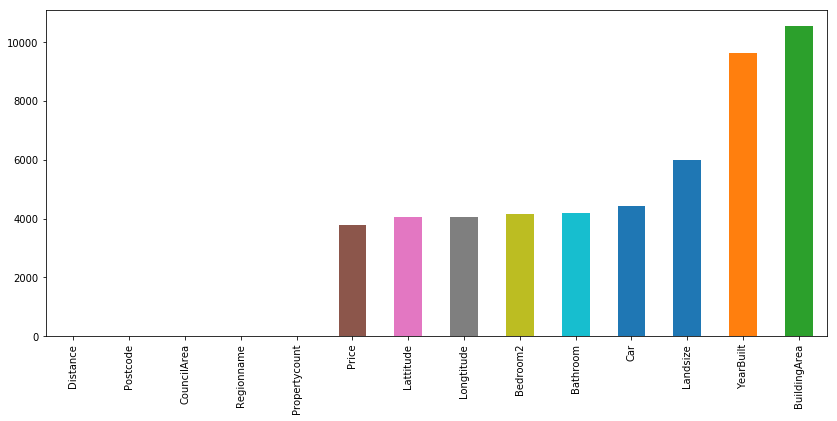

In [7]:
_, axes = plt.subplots(figsize=(14, 6))
missing = df_train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

In [8]:
#Time to start the clean up process

#Fill in Categorical
categorical_features = df_train.select_dtypes(include='object').columns
df_train[categorical_features] = df_train[categorical_features].fillna('None')
df_test[categorical_features] = df_test[categorical_features].fillna('None')

In [9]:
#Numerical features next:
num_features = ['Price', 'Landsize', 'BuildingArea']
df_train[num_features] = df_train.groupby("Suburb")[num_features].transform(
    lambda x: x.fillna(x.median()))
df_test[num_features] = df_test.groupby("Suburb")[num_features].transform(
    lambda x: x.fillna(x.median()))



In [10]:
#Train-Test Join

idx_split = df_train.shape[0]
df_train = df_train.append(df_test)

In [11]:
NumStr = ['Postcode', 'YearBuilt', 'Propertycount']

for col in NumStr:
    df_train[col]=df_train[col].astype(str)
    
    
non_ordinal_features = ['Regionname', 'Method']
ordinal_features = df_train.select_dtypes(include='object').columns.drop(non_ordinal_features)

In [12]:
#Dummies for Categorical Variables

dummies = pd.get_dummies(df_train.loc[:,non_ordinal_features], drop_first=True)
df_train = pd.concat([df_train,dummies], axis=1)
df_train = df_train.drop(non_ordinal_features,axis=1)


In [13]:
def cat_to_num(x):
    if x=='br':
        return 0
    if x=='u':
        return 1
    if x=='dev site':
        return 2
    if x=='o res': 
        return 3
    if x=='t':
        return 4
    if x=='h':
        return 5
    
df_train.loc[:,'Type'] = df_train.loc[:,'Type'].apply(cat_to_num)

In [14]:
#Split them back up
df_train = df_train.dropna(subset=['Price'])
X = df_train.loc[:idx_split, :]
X_test = df_train.loc[idx_split+1:, :]
Y = X['Price']
Y_test = X_test['Price']
print(X.shape)

(10324, 35)


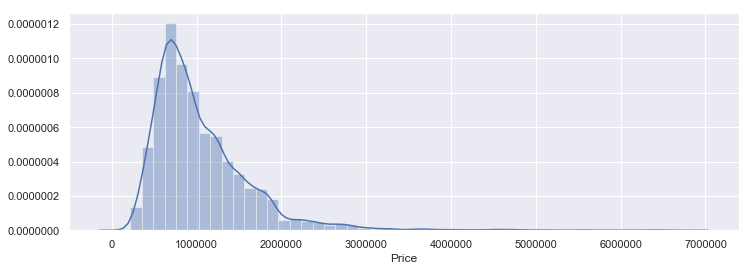

In [15]:
sns.set()
_, axes = plt.subplots(figsize=(12, 4))
sns.distplot(X.Price)

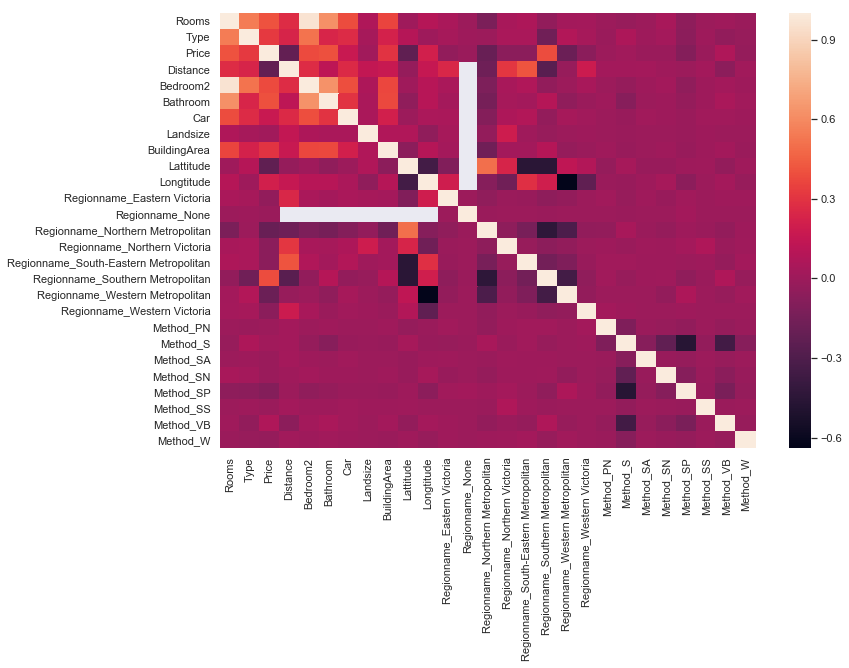

In [16]:
#Force Heatmap from 1: -1

_, ax = plt.subplots(ncols=1, figsize=(12,8))
corr_matrix = X.corr()
sns.heatmap(corr_matrix);

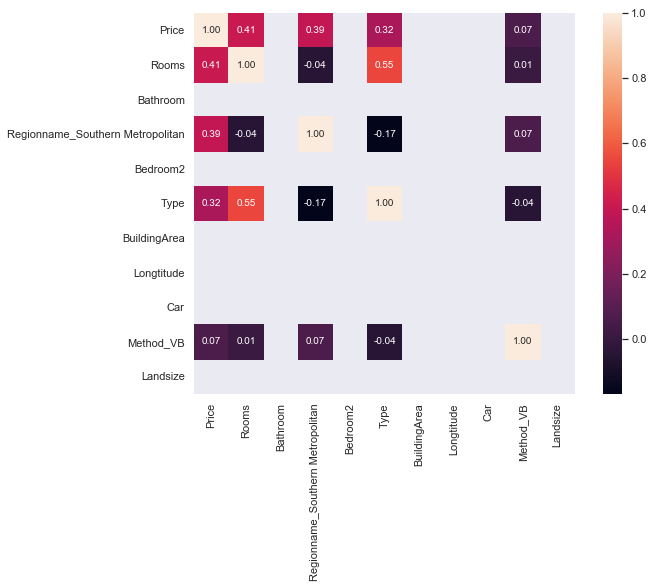

In [17]:
_, ax = plt.subplots(ncols=1, figsize=(10,7))
cols = corr_matrix.nlargest(11, 'Price')['Price'].index
cm = np.corrcoef(X[cols].values.T)
sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)

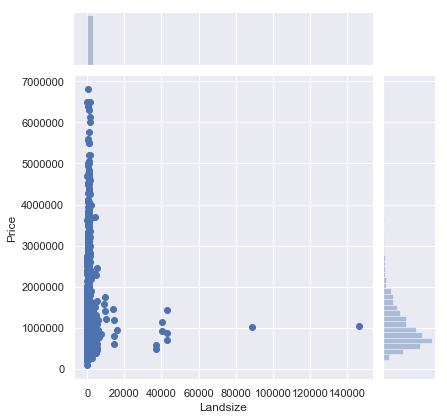

In [18]:
sns.set()
sns.jointplot(kind='scatter',data=X, x='Landsize', y='Price')

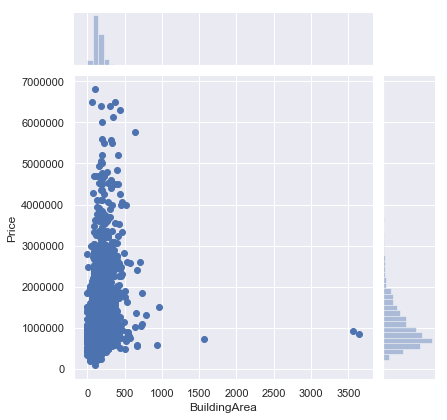

In [19]:
sns.set()
sns.jointplot(kind='scatter',data=X, x='BuildingArea', y='Price')

Here we can see that some very large properties are skewing our results significantly

In [20]:
#print(X.Price)

#Predictors-Target Split

## Feature Engineering

Let's create some of our own variables: 

Totalfootage:  building area and land size combined


In [21]:
X['Totalfootage'] = X['BuildingArea'] + X['Landsize']

X_test['Totalfootage'] = X['BuildingArea'] + X['Landsize']

# Handling Outliers

In [22]:
X = X.drop(X[X['BuildingArea']>5000].index)

In [23]:
X2 = X.select_dtypes(exclude='object')

X2 = X2.fillna(0)
#print(X2.dtypes)
print(X2.shape)
print(Y.shape)
print(X.shape)


(10324, 28)
(10324,)
(10324, 36)


In [24]:
# Create new Pricing once we drop the outliers:

Y2 = X2.Price
X2= X2.drop(columns='Price')

In [25]:
#Time to add in a linear regression
from sklearn import linear_model
import statsmodels.formula.api as smf
regr = linear_model.LinearRegression()
regr.fit(X2,Y2)

print(regr.score(X2, Y2))

0.5064817930617735


In [26]:
#Cross Val
from sklearn.model_selection import cross_val_score
cross_val_score(regr, X2, Y2, cv=10)

array([0.52050231, 0.4286889 , 0.49940589, 0.51071854, 0.49805903,
       0.53757945, 0.56146956, 0.46417235, 0.46534497, 0.54071089])

In [27]:
#Now let's see how a random forest decision tree would handle this

In [28]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
rfr = ensemble.RandomForestRegressor()
rfr.fit(X2, Y2)
cross_val_score(rfr, X2, Y2, cv=5)

array([0.59193427, 0.55464527, 0.63804501, 0.58026095, 0.58354497])

In [40]:
from sklearn.neural_network import MLPRegressor

MLPR = MLPRegressor(hidden_layer_sizes=(100,100,100,))
MLPR.fit(X2, Y2)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 100, 100), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [41]:
MLPR.score(X2, Y2)

0.13278639471764864

In [42]:
cross_val_score(MLPR, X2, Y2, cv=5)

array([0.37954132, 0.09069893, 0.52209922, 0.096877  , 0.2041186 ])

MLPR seriously overfit to my linear equation.  This can be seen when it attempts to solve for portions of the data set.  Reaching a low of .1353.  This is incredibly interesting in the fact that I was not expecting it to overfit so heavily.  One way to combat this would be to split up the data set more and only allow it to train on one portion or potentially add in more layers to the neural network with more perceptrons.  

when running and shifting the parameters.  My model performs worse and worse over time as it continues to overfit or perhaps experience worse and worse constraints